In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline 
import scipy.io as scio
import os

In [23]:
Data = scio.loadmat("data/All_PC_Data.mat")
I = Data["images"]; State = Data['state']; Patient = Data['labels_pat']

In [6]:
I.shape

(101, 101, 842)

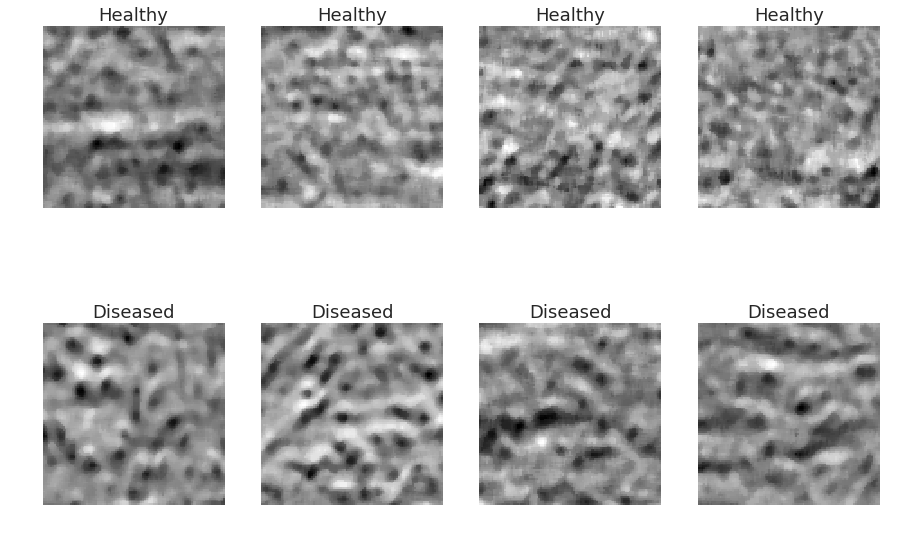

In [95]:
rand_idx_1 = np.random.choice(np.where(State==0)[1],4,replace=False)
rand_idx_2 = np.random.choice(np.where(State==1)[1],4,replace=False)
rand_idx = np.concatenate([rand_idx_1,rand_idx_2])
f = plt.subplots(2,4, figsize=(15,10))
for i,j in enumerate(rand_idx):
    ax = plt.subplot(2,4,i/1.0+1)
    plt.imshow(I[:,:,j],cmap='gray')
    if i<4: ax.set_title('Healthy')
    else: ax.set_title('Diseased')
    plt.axis('off')

### CaffeNet using Caffe

In [4]:
import sys
caffe_root = '/home/labuser/Documents/AA_DL_Caffe/caffe/'
sys.path.insert(0, caffe_root+'python')

import caffe
caffe.set_mode_cpu()

model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weight = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def, model_weight, caffe.TEST)

In [9]:
# set the size of input
net.blobs['data'].reshape(50,        # batch size 
                        3,          # 3-channel(BGR) images
                        227, 227)   # image size

mu = np.load(caffe_root+'python/caffe/imagenet/ilsvrc_2012_mean.npy') # mu:(3, 256, 256)
mu = mu.mean(1).mean(1) # Obtain the mean (BGR) pixel values

transformer = caffe.io.Transformer({'data':net.blobs['data'].data.shape})

#perform basic pre-processing of current image data
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

In [68]:
blob_names = ['conv1','conv2','conv3','conv4','conv5','fc6','fc7','fc8']
def extract_ots_caffe(images,blob_names):
    
    blob_dict = {}
    for blob in blob_names:
        blob_dict[blob] = []
    
    for i in range(0,images.shape[2]):
        image = images[:,:,i]
        image = (image - np.mean(image))/np.mean(image)
        image_3d = np.dstack((np.dstack((image,image)),image))
        transform_image = transformer.preprocess('data', image_3d)
        net.blobs['data'].data[...] = transform_image
        output = net.forward()
        
        for blob in blob_names:
            feature = net.blobs[blob].data[0,:]
            if "fc" in blob:
                blob_dict[blob].append(list(feature))    
            elif "conv" in blob:                #Global Average Pooling in case of conv layers
                blob_dict[blob].append(np.mean(np.mean(feature, axis=1),axis=1))
                
        print "finished %d image" % i
                
    return blob_dict

In [12]:
#blob_names = ['fc6']
caffe_feature_dict = extract_ots_caffe(I,blob_names)

finished 0 image
finished 1 image


In [82]:
res_dir = "results/CaffeNet/"
#os.mkdir(res_dir)
caffe_features_path = [res_dir + j + "/feat_" + j + ".csv" for i,j in enumerate(blob_names)]
caffe_features_path
for i,j in enumerate(blob_names):
    os.mkdir(res_dir+j)
    np.savetxt(caffe_features_path[i],feature_dict[j], delimiter=',')

['results/CaffeNet/conv1/feat_conv1.csv',
 'results/CaffeNet/conv2/feat_conv2.csv',
 'results/CaffeNet/conv3/feat_conv3.csv',
 'results/CaffeNet/conv4/feat_conv4.csv',
 'results/CaffeNet/conv5/feat_conv5.csv',
 'results/CaffeNet/fc6/feat_fc6.csv',
 'results/CaffeNet/fc7/feat_fc7.csv',
 'results/CaffeNet/fc8/feat_fc8.csv']

## Inception v3 Model - Using Lasagne

In [1]:
from Inception_Network_file.py import *

In [2]:
#initialize the different layers for the model
net = {}

net['input'] = InputLayer((None, 3, 299, 299))
net['conv'] = bn_conv(net['input'],
                      num_filters=32, filter_size=3, stride=2) # input size (None, 3, 299, 299)
net['conv_1'] = bn_conv(net['conv'], num_filters=32, filter_size=3) # input size(None, 32, 149, 149)
net['conv_2'] = bn_conv(net['conv_1'],
                        num_filters=64, filter_size=3, pad=1) # (None, 32, 147, 147)
net['pool'] = Pool2DLayer(net['conv_2'], pool_size=3, stride=2, mode='max') # (None, 64, 147, 147)

net['conv_3'] = bn_conv(net['pool'], num_filters=80, filter_size=1) # (None, 64, 73, 73)

net['conv_4'] = bn_conv(net['conv_3'], num_filters=192, filter_size=3) #(None, 80, 73, 73)

net['pool_1'] = Pool2DLayer(net['conv_4'],
                            pool_size=3, stride=2, mode='max') #(None, 192, 71, 71)
net['mixed/join'] = inceptionA(
    net['pool_1'], nfilt=((64,), (48, 64), (64, 96, 96), (32,))) # (None, 192, 35, 35)
net['mixed_1/join'] = inceptionA(
    net['mixed/join'], nfilt=((64,), (48, 64), (64, 96, 96), (64,)))

net['mixed_2/join'] = inceptionA(
    net['mixed_1/join'], nfilt=((64,), (48, 64), (64, 96, 96), (64,)))

net['mixed_3/join'] = inceptionB(
    net['mixed_2/join'], nfilt=((384,), (64, 96, 96))) #(None, 288, 35, 35)

net['mixed_4/join'] = inceptionC(
    net['mixed_3/join'],
    nfilt=((192,), (128, 128, 192), (128, 128, 128, 128, 192), (192,))) # (None, 768, 17, 17)

net['mixed_5/join'] = inceptionC(
    net['mixed_4/join'],
    nfilt=((192,), (160, 160, 192), (160, 160, 160, 160, 192), (192,)))

net['mixed_6/join'] = inceptionC(
    net['mixed_5/join'],
    nfilt=((192,), (160, 160, 192), (160, 160, 160, 160, 192), (192,)))

net['mixed_7/join'] = inceptionC(
    net['mixed_6/join'],
    nfilt=((192,), (192, 192, 192), (192, 192, 192, 192, 192), (192,))) 

net['mixed_8/join'] = inceptionD(
    net['mixed_7/join'],
    nfilt=((192, 320), (192, 192, 192, 192))) #(None, 768, 17, 17)

net['mixed_9/join'] = inceptionE(
    net['mixed_8/join'],
    nfilt=((320,), (384, 384, 384), (448, 384, 384, 384), (192,)),
    pool_mode='average_exc_pad') # (None, 1280, 8, 8)

net['mixed_10/join'] = inceptionE(
    net['mixed_9/join'],
    nfilt=((320,), (384, 384, 384), (448, 384, 384, 384), (192,)),
    pool_mode='max') # (None, 2048, 8, 8)

net['pool3'] = GlobalPoolLayer(net['mixed_10/join'])

net['softmax'] = DenseLayer(
    net['pool3'], num_units=1008, nonlinearity=softmax)

output_layer = net['softmax']

In [3]:
import pickle
model = pickle.load(open('inception_v3.pkl'))

CLASSES = model['synset words']

lasagne.layers.set_all_param_values(output_layer, model['param values'])

In [4]:
def extract_ots_inception(images, blob_names):
    
    blob_dict = {}
    for blob in blob_names:
        blob_dict[blob] = []
    
    for i in range(0,images.shape[2]):
        image = skimage.transform.resize(images[:,:,i],(299, 299), preserve_range=True)
        image = (image - np.mean(image))/np.mean(image)
        image_3d = np.dstack((np.dstack((image,image)),image))
        after_roll = np.rollaxis(image_3d, 2)[np.newaxis].astype('float32')
        
        prob_med = np.array(lasagne.layers.get_output(net['pool3'], after_roll, deterministic=True).eval())
        
        for blob in blob_names:
            
            feature = lasagne.layers.get_output(net[blob], after_roll, deterministic=True).eval()
            if "pool" in blob:
                blob_dict[blob].append(list(feature))
               
            elif "mixed" in blob:
                blob_dict[blob].append(np.mean(np.mean(feature, axis=2),axis=1))
                
        if i%100 == 0: 
            print "finished %d image" % i
            print datetime.datetime.now() 
            
                
    return blob_dict

In [83]:
blob_names = ["mixed/join", "mixed_1/join", "mixed_2/join", "mixed_3/join", "mixed_4/join", "mixed_5/join",
             "mixed_6/join", "mixed_7/join", "mixed_8/join", "mixed_9/join", "mixed_10/join"]

inception_feature_dict = extract_ots_inception(I,blob_names)

In [85]:
res_dir = "results/Inception/"
#os.mkdir(res_dir)
inception_features_path = [res_dir + j[:-5] + "/feat_" + j[:-5] + ".csv" for i,j in enumerate(blob_names)]
inception_features_path
for i,j in enumerate(blob_names):
    os.mkdir(res_dir+j[:-5])
    np.savetxt(inception_features_path[i],feature_dict[j], delimiter=',')

['results/Inception/mixed/feat_mixed.csv',
 'results/Inception/mixed_1/feat_mixed_1.csv',
 'results/Inception/mixed_2/feat_mixed_2.csv',
 'results/Inception/mixed_3/feat_mixed_3.csv',
 'results/Inception/mixed_4/feat_mixed_4.csv',
 'results/Inception/mixed_5/feat_mixed_5.csv',
 'results/Inception/mixed_6/feat_mixed_6.csv',
 'results/Inception/mixed_7/feat_mixed_7.csv',
 'results/Inception/mixed_8/feat_mixed_8.csv',
 'results/Inception/mixed_9/feat_mixed_9.csv',
 'results/Inception/mixed_10/feat_mixed_10.csv']

## Machine Learning and Classification

In [27]:
import sklearn.svm as svm
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from scipy import interp

sns.set_palette('muted')
palette = np.array(sns.color_palette("hls", 10))

In [24]:
# Getting CVV indices based on patient information

te=np.array([[1,3],[1,4],[1,5],[2,3],[2,4],[2,5]])
tr=np.array([[2,4,5],[2,3,5],[2,3,4],[1,4,5],[1,3,5],[1,3,4]])
te_idx={}
tr_idx={}
for i in range(0,6):
    te_idx[i] = np.concatenate([np.where(Patient==te[i][0])[1],np.where(Patient==te[i][1])[1]])
    tr_idx[i] = np.concatenate([np.where(Patient==tr[i][0])[1],np.where(Patient==tr[i][1])[1],np.where(Patient==tr[i][2])[1]])

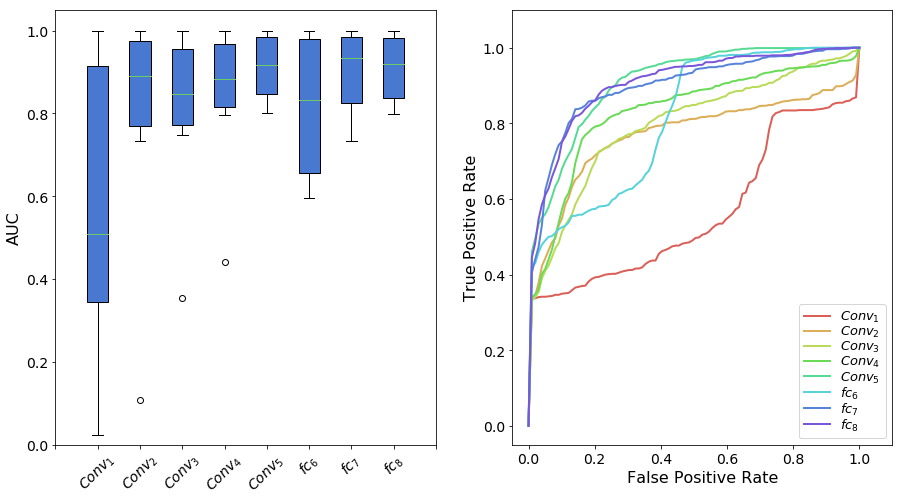

In [29]:
# CaffeNet Features

f, (ax1,ax2) = plt.subplots(1,2, figsize=(15,8))
auc_vals = np.zeros((len(feature_path),6))
tick_lab = np.array([0.0,0.2,0.4,0.6,0.8,1])
for j in range(0,len(caffe_features_path)):
    
    feature_matrix =np.loadtxt(caffe_features_path[j],delimiter=",")
    #tr1, tr2, tr3, tr4, tr5, tr6, t1, t2, t3, t4, t5, t6 = split_matrix_to_patient(feature_matrix)
    
    random_state = np.random.RandomState(0)
    clf = svm.SVC(gamma=0.001, C=100., probability=True, random_state=random_state)
    name = ['$Conv_1$','$Conv_2$','$Conv_3$','$Conv_4$','$Conv_5$','$fc_6$','$fc_7$','$fc_8$']

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    
    for i in range(0,6):
        train= np.concatenate([feature_matrix[tr_idx[i],:],State.T[tr_idx[i]]],axis=1)
        test = np.concatenate([feature_matrix[te_idx[i],:],State.T[te_idx[i]]],axis=1)
        clf.fit(train[:,:-1],np.ravel(train[:,-1:]))
        probas = clf.predict_proba(test[:,:-1])
        fpr, tpr, thresholds = roc_curve(test[:,-1:], probas[:,1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        
        auc_vals[j,i] = roc_auc_score(test[:,-1:], probas[:,1])
    
    
    mean_tpr /= 6
    mean_tpr[-1] = 1.0
    ax2.plot(mean_fpr, mean_tpr, 'k-',
             label='%s' % name[j], lw=2, c=palette[j])
    ax2.set_xlim([-0.05, 1.1])
    ax2.set_ylim([-0.05, 1.1])
    ax2.set_xlabel('False Positive Rate',fontsize=16)
    ax2.set_ylabel('True Positive Rate',fontsize=16)
    ax2.set_xticks(tick_lab)
    ax2.set_yticks(tick_lab)
    ax2.set_xticklabels(tick_lab,fontsize=14)
    ax2.set_yticklabels(tick_lab,fontsize=14)
    legend = ax2.legend(loc=4,prop={'size':13}, labelspacing=0)
    ax2.grid('off')
    
x = np.array([0,1,2,3,4,5,6,7,8,9])
y = np.append(np.hstack((-1,np.mean(auc_vals,axis=1))),-1)
s = np.array(np.append(np.hstack((0,np.std(auc_vals,axis=1))),0))

name.insert(0,' ')
name.append(' ')
x_layer = name
bp = ax1.boxplot(auc_vals.T,patch_artist=True)

#x_layer = name
ax1.set_xticks(x)
ax1.set_xticklabels(x_layer,fontsize=14,rotation=45)
ax1.set_yticks(tick_lab)
ax1.set_yticklabels(tick_lab,fontsize=14)
ax1.set_ylabel("AUC",fontsize=16)
ax1.set_ylim([0,1.05]) 
ax1.grid('off')

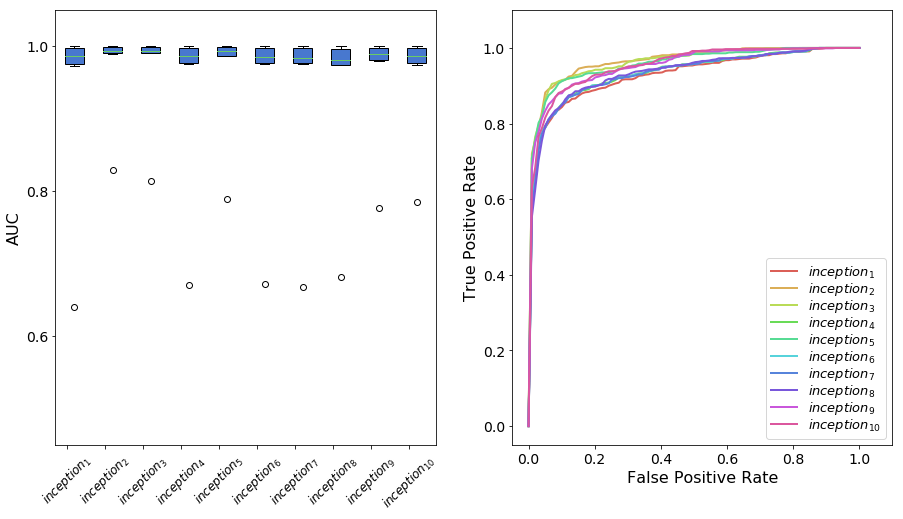

In [28]:
# Inception Network Features
f, (ax1,ax2) = plt.subplots(1,2, figsize=(15,8))
auc_vals = np.zeros((len(inception_layer_path),6))

for j in range(0,len(inception_features_path)):
    
    feature_matrix =np.loadtxt(inception_features_path[j],delimiter=",")
    #tr1, tr2, tr3, tr4, tr5, tr6, t1, t2, t3, t4, t5, t6 = split_matrix_to_patient(feature_matrix)
    
    random_state = np.random.RandomState(0)
    clf = svm.SVC(gamma=0.001, C=100., probability=True, random_state=random_state)
    #train = [tr1,tr2,tr3,tr4,tr5,tr6]
    #test = [t1,t2,t3,t4,t5,t6]
    #name = ['$Conv_1$','$Conv_2$','$Conv_3$','$Conv_4$','$Conv_5$','$fc_6$','$fc_7$','$fc_8$']
    name = ['$inception_1$','$inception_2$','$inception_3$','$inception_4$','$inception_5$',
            '$inception_6$','$inception_7$','$inception_8$','$inception_9$','$inception_{10}$']
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    
    for i in range(0,6):
        train= np.concatenate([feature_matrix[tr_idx[i],:],State.T[tr_idx[i]]],axis=1)
        test = np.concatenate([feature_matrix[te_idx[i],:],State.T[te_idx[i]]],axis=1)
        clf.fit(train[:,:-1],np.ravel(train[:,-1:]))
        probas = clf.predict_proba(test[:,:-1])
        fpr, tpr, thresholds = roc_curve(test[:,-1:], probas[:,1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        
        auc_vals[j,i] = roc_auc_score(test[:,-1:], probas[:,1])
    
    
    mean_tpr /= 6
    mean_tpr[-1] = 1.0
    ax2.plot(mean_fpr, mean_tpr, 'k-',
             label='%s' % name[j], lw=2, c=palette[j])
    ax2.set_xlim([-0.05, 1.1])
    ax2.set_ylim([-0.05, 1.1])
    ax2.set_xlabel('False Positive Rate',fontsize=16)
    ax2.set_ylabel('True Positive Rate',fontsize=16)
    ax2.set_xticks(tick_lab)
    ax2.set_yticks(tick_lab)
    ax2.set_xticklabels(tick_lab,fontsize=14)
    ax2.set_yticklabels(tick_lab,fontsize=14)
    legend = ax2.legend(loc=4,prop={'size':13}, labelspacing=0)
    ax2.grid('off')
    
x = np.array([1,2,3,4,5,6,7,8,9,10])-0.2
y = np.append(np.hstack((-1,np.mean(auc_vals,axis=1))),-1)
s = np.array(np.append(np.hstack((0,np.std(auc_vals,axis=1))),0))
bp = ax1.boxplot(auc_vals.T,patch_artist=True)


x_layer = ['$inception_1$','$inception_2$','$inception_3$','$inception_4$','$inception_5$',
            '$inception_6$','$inception_7$','$inception_8$','$inception_9$','$inception_{10}$']
ax1.set_xticks(x)
ax1.set_xticklabels(x_layer, fontsize = 12,rotation=45)
ax1.set_yticks(tick_lab)
ax1.set_yticklabels(tick_lab,fontsize=14)
ax1.set_ylabel("AUC",fontsize=16)
ax1.set_ylim([0.45,1.05])
ax1.grid('off')

In [34]:
glcm_feature_path = "results/GLCM/"
glcm_layer_path_2 = ["absv.csv","cont.csv","homo.csv","entr.csv","ener.csv",
                       "corr.csv"]

(0, 1.15)

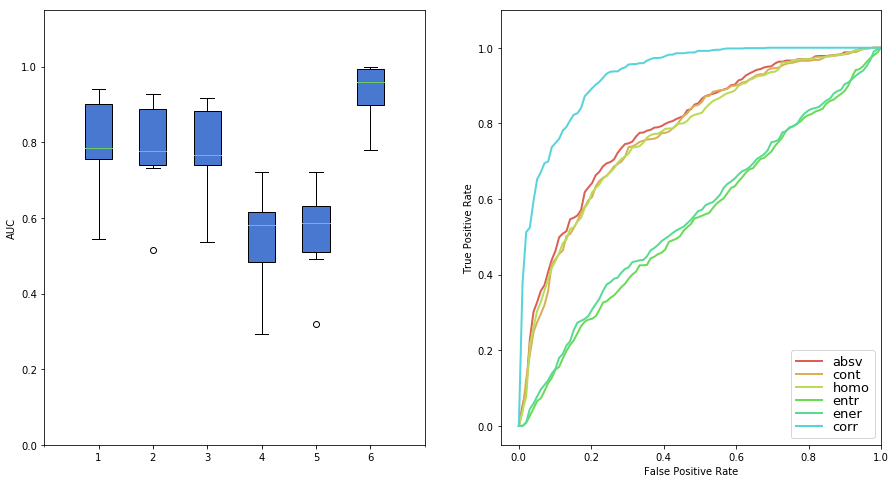

In [37]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(15,8))
auc_vals = np.zeros((6,6))

for j in range(0,len(glcm_layer_path_2)):
    
    feature_matrix =np.loadtxt(glcm_feature_path+glcm_layer_path_2[j],delimiter=",")
    feature_matrix = feature_matrix.reshape(842,1)
    
    
    random_state = np.random.RandomState(0)
    clf = svm.SVC(gamma=0.001, C=100., probability=True, random_state=random_state)

    #name = ['$Conv_1$','$Conv_2$','$Conv_3$','$Conv_4$','$Conv_5$','$fc_6$','$fc_7$','$fc_8$']
    name = glcm_layer_path_2
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    
    for i in range(0,6):
        train= np.concatenate([feature_matrix[tr_idx[i],:],State.T[tr_idx[i]]],axis=1)
        test = np.concatenate([feature_matrix[te_idx[i],:],State.T[te_idx[i]]],axis=1)
        clf.fit(train[:,:-1],np.ravel(train[:,-1:]))
        probas = clf.predict_proba(test[:,:-1])
        fpr, tpr, thresholds = roc_curve(test[:,-1:], probas[:,1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        
        auc_vals[j,i] = roc_auc_score(test[:,-1:], probas[:,1])
    
    
    mean_tpr /= 6
    mean_tpr[-1] = 1.0
    ax2.plot(mean_fpr, mean_tpr, 'k-',
             label='%s' % name[j][:-4], lw=2, c=palette[j])
    ax2.set_xlim([-0.05, 1.0])
    ax2.set_ylim([-0.05, 1.1])
    ax2.set_xlabel('False Positive Rate',fontsize=10)
    ax2.set_ylabel('True Positive Rate',fontsize=10)
    legend = ax2.legend(loc=4,prop={'size':13}, labelspacing=0)
    ax2.grid('off')
    
x = np.array([0,1,2,3,4,5,6,7])
y = np.append(np.hstack((-1,np.mean(auc_vals,axis=1))),-1)
s = np.array(np.append(np.hstack((0,np.std(auc_vals,axis=1))),0))
#ax1.axis("off")

bp = ax1.boxplot(auc_vals.T,patch_artist=True)

x_layer = name
ax1.set_xticks(x, x_layer)
ax1.set_ylabel("AUC")
ax1.set_ylim([0,1.15])

# plt.savefig("caffenet_compare.eps", format='eps', dpi=1000)

### Additional Visualizations using tSNE

In [38]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel
from scipy.spatial.distance import squareform, pdist

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})


In [39]:
def _joint_probabilities_constant_sigma(D, sigma):
    P = np.exp(-D**2/2 * sigma**2)
    P /= np.sum(P, axis=1)
    return P

In [40]:
def pca(X = np.array([]), no_dims = 50):
	"""Runs PCA on the NxD array X in order to reduce its dimensionality to no_dims dimensions."""

	print "Preprocessing the data using PCA..."
	(n, d) = X.shape;
	X = X - np.tile(np.mean(X, 0), (n, 1));
	(l, M) = np.linalg.eig(np.dot(X.T, X));
	Y = np.dot(X, M[:,0:no_dims]);
	return Y;

In [41]:
def scatter_new(x, colors,ax):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    # f = plt.figure(figsize=(5, 5))
    # ax = plt.subplot(aspect='equal')
    
    healthy_ind = np.where(colors==0)
    disease_ind = np.where(colors==1)
    
    heal = ax.scatter(x[healthy_ind,0], x[healthy_ind,1], s=50,
                    c='r')
    dise = ax.scatter(x[disease_ind,0], x[disease_ind,1], s=50,
                    c='b',marker='^')
    
    ax.set_xlim(-40, 40)
    ax.set_ylim(-40, 40)
    ax.grid('off')
    ax.set_facecolor('white')
    ax.axhline(y=0, color='k',Linewidth=0.9, alpha=0.5, linestyle='--')
    ax.axvline(x=0, color='k',Linewidth=0.9, alpha=0.5, linestyle='--')

    plt.legend((heal,dise),('Healthy','Osteoarthritic'),loc=4)

    return

In [88]:
sel_features = [caffe_features_path[4],caffe_features_path[7], inception_features_path[3],inception_features_path[10]]
sel_features

['results/CaffeNet/conv5/feat_conv5.csv',
 'results/CaffeNet/fc8/feat_fc8.csv',
 'results/Inception/mixed_3/feat_mixed_3.csv',
 'results/Inception/mixed_10/feat_mixed_10.csv']

In [92]:
features_vis = []
for i in range(0,len(sel_features)):
    X = np.loadtxt(sel_features[i],delimiter=',')
    # Pairwise distances between all data points.
    D = pairwise_distances(X, squared=True)
    # Similarity with constant sigma.
    P_constant = _joint_probabilities_constant_sigma(D, .002)
    # Similarity with variable sigma.
    P_binary = _joint_probabilities(D, 30., False)
    # The output of this function needs to be reshaped to a square matrix.
    P_binary_s = squareform(P_binary)
    X = pca(X,50).real
    features_vis.append(TSNE(perplexity=20,n_iter=700,method='exact',early_exaggeration=4).fit_transform(X))


Preprocessing the data using PCA...
Preprocessing the data using PCA...
Preprocessing the data using PCA...
Preprocessing the data using PCA...


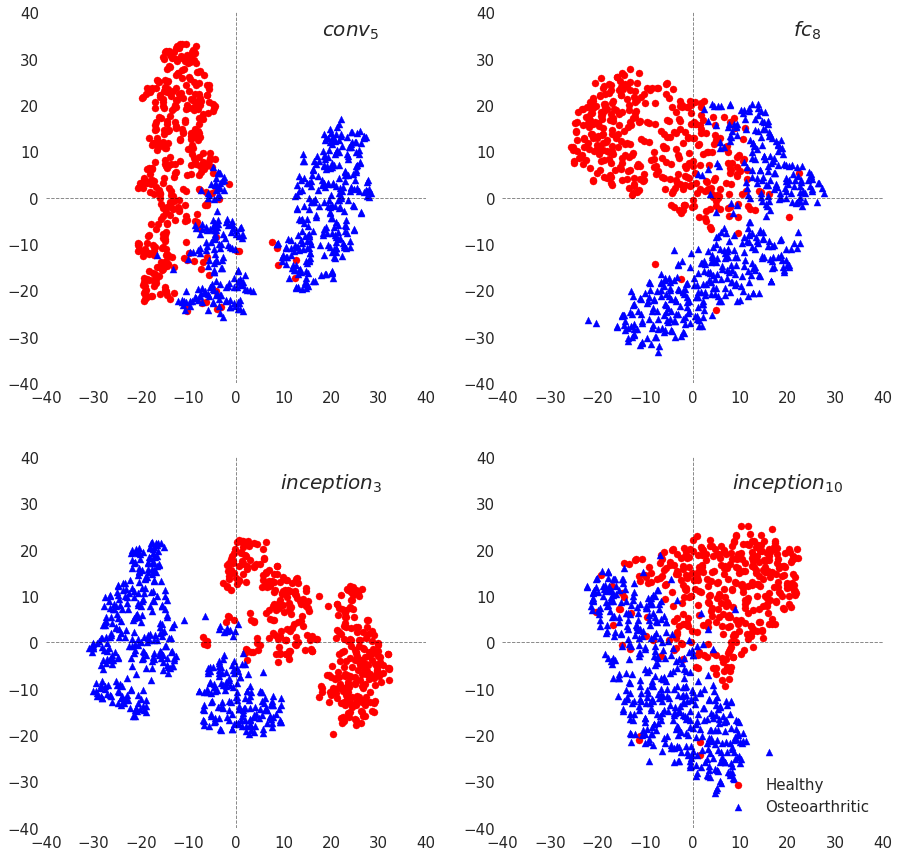

In [46]:
f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,15))
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
#                wspace=0, hspace=0)


scatter_new(features_vis[0], State, ax1)
ax1.set_title("$conv_5$")
tt1 = ax1.title
tt1.set_position([0.8, 0.92])
tt1.set_size(20)

scatter_new(features_vis[1], State, ax2)
ax2.set_title("$fc_8$")
tt2 = ax2.title
tt2.set_position([0.8, 0.92])
tt2.set_size(20)

scatter_new(features_vis[2], State, ax3)
ax3.set_title("$inception_3$")
tt3 = ax3.title
tt3.set_position([0.75, 0.9])
tt3.set_size(20)

scatter_new(features_vis[3], State, ax4)
ax4.set_title("$inception_{10}$")
tt4 = ax4.title
tt4.set_position([0.75, 0.9])
tt4.set_size(20)

In [89]:
tsne_list = []
for i in range(0,len(inception_features_path)):
    X = np.loadtxt(inception_path_list[i],delimiter=',')
    # Pairwise distances between all data points.
    D = pairwise_distances(X, squared=True)
    # Similarity with constant sigma.
    P_constant = _joint_probabilities_constant_sigma(D, .002)
    # Similarity with variable sigma.
    P_binary = _joint_probabilities(D, 30., False)
    # The output of this function needs to be reshaped to a square matrix.
    P_binary_s = squareform(P_binary)
    X = pca(X,50).real
    tsne_list.append(TSNE(perplexity=20,n_iter=700,method='exact',early_exaggeration=4).fit_transform(X))

Preprocessing the data using PCA...
Preprocessing the data using PCA...
Preprocessing the data using PCA...
Preprocessing the data using PCA...
Preprocessing the data using PCA...
Preprocessing the data using PCA...
Preprocessing the data using PCA...
Preprocessing the data using PCA...
Preprocessing the data using PCA...
Preprocessing the data using PCA...


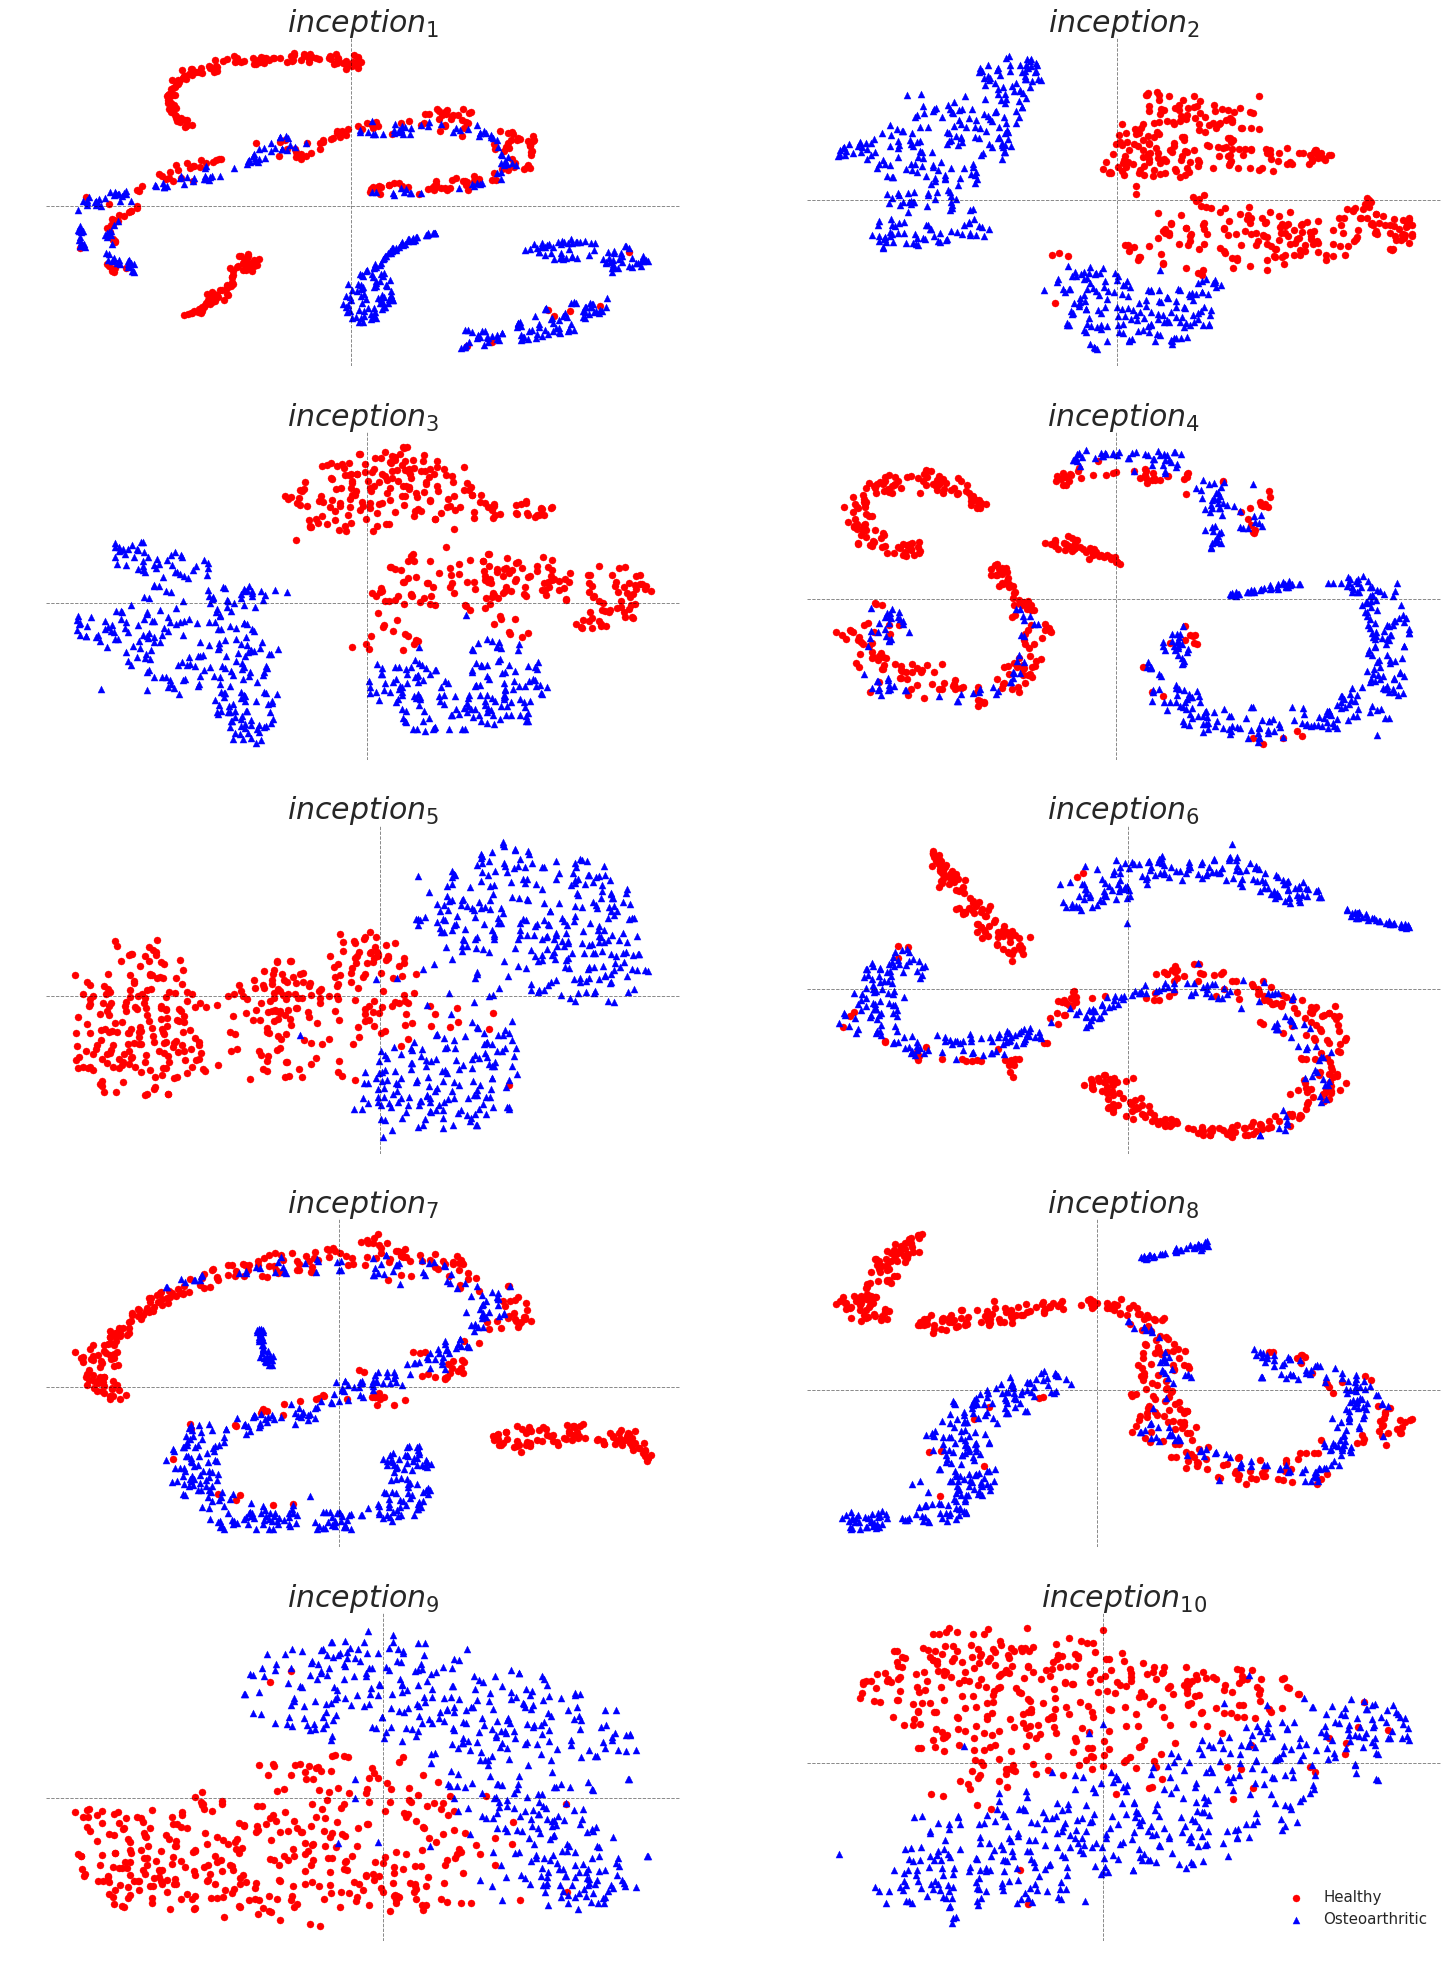

In [90]:
f,myplot_axes = plt.subplots(5,2,figsize=(25,35))
for xctr in range(0,5):
    for yctr in (0,1):
        ax6 = myplot_axes[xctr,yctr];
        ax6.set_aspect('auto')
        scatter_new(np.asarray(tsne_list[xctr*2 + yctr]), State,ax6)
        #ax6.axis('square')
        ax6.axis('off')
        ax6.axis('auto')
        ax6.set_title("$inception_{" + repr(xctr*2 + yctr + 1) +"}$")
        #if (xctr*2 + yctr) == 9:
         #   [ax6.set_title("$" + inception_path_list[xctr*2 + yctr][-9:-4] +"$")]
        tt6 = ax6.title
        tt6.set_position([0.5, 1])
        tt6.set_size(30)